In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
import yfinance as yf
from core.strategy import run_static_strategy

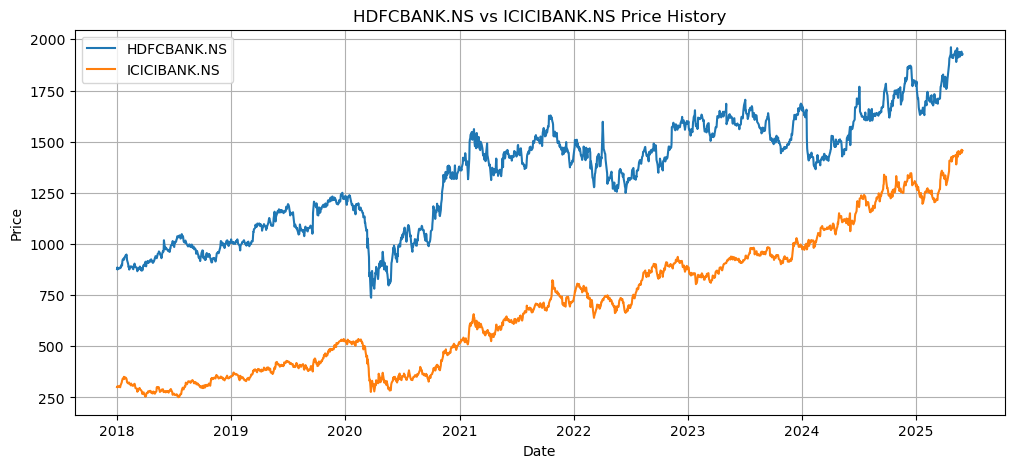

In [26]:
# focus on these two stocks
pick1 = "HDFCBANK.NS"
pick2 = "ICICIBANK.NS"
start_date = "2018-01-01"
end_date = "2025-05-30"
split_date = "2020-03-01"

data1 = yf.Ticker(pick1).history(start=start_date, end=end_date)["Close"]
data2 = yf.Ticker(pick2).history(start=start_date, end=end_date)["Close"]

data = pd.DataFrame({pick1: data1, pick2: data2}).dropna()

# plot their stock price history
plt.figure(figsize=(12, 5))
plt.plot(data.index, data[pick1], label=pick1)
plt.plot(data.index, data[pick2], label=pick2)
plt.title(f"{pick1} vs {pick2} Price History")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

Correlation between HDFCBANK.NS and ICICIBANK.NS (training set): 0.8828
Intercept: -292.3356, Slope: 0.6341


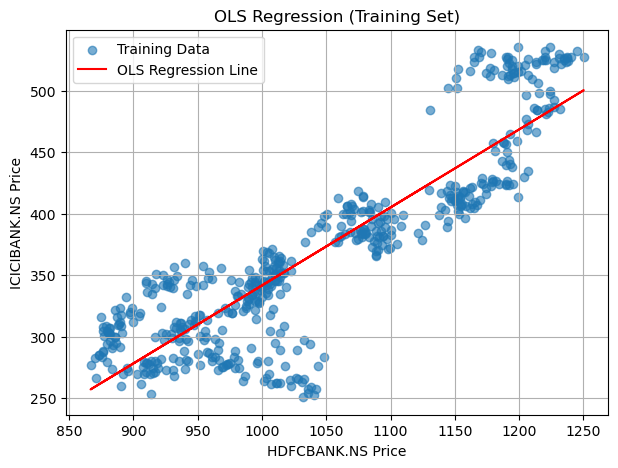

In [27]:
# split
train_data = data[data.index < split_date]
test_data = data[data.index >= split_date]

# correlation
correlation = train_data[pick1].corr(train_data[pick2])
print(f"Correlation between {pick1} and {pick2} (training set): {correlation:.4f}")

# linear regression
X = sm.add_constant(train_data[pick1])
Y = train_data[pick2]
model = sm.OLS(Y, X).fit()

intercept, slope = model.params
print(f"Intercept: {intercept:.4f}, Slope: {slope:.4f}")

# plot regression line
plt.figure(figsize=(7, 5))
plt.scatter(train_data[pick1], train_data[pick2], label="Training Data", alpha=0.6)
reg_line = intercept + slope * train_data[pick1]
plt.plot(train_data[pick1], reg_line, color="red", label="OLS Regression Line")
plt.xlabel(f"{pick1} Price")
plt.ylabel(f"{pick2} Price")
plt.title("OLS Regression (Training Set)")
plt.legend()
plt.grid(True)
plt.show()

In [28]:
# cointegration (all data)
score_full, pval_full, _ = coint(data[pick1], data[pick2])
print("=== Cointegration Test: Full Data ===")
print(f"  Test Statistic: {score_full:.4f}")
print(f"  P-value: {pval_full:.4f}")
if pval_full < 0.05:
    print("  ✅ Likely cointegrated (p < 0.05)\n")
else:
    print("  ❌ No strong evidence of cointegration (p ≥ 0.05)\n")

# cointegration (test data)
score_train, pval_train, _ = coint(train_data[pick1], train_data[pick2])
print("=== Cointegration Test: Training Data ===")
print(f"  Test Statistic: {score_train:.4f}")
print(f"  P-value: {pval_train:.4f}")
if pval_train < 0.05:
    print("  ✅ Likely cointegrated (p < 0.05)")
else:
    print("  ❌ No strong evidence of cointegration (p ≥ 0.05)")

=== Cointegration Test: Full Data ===
  Test Statistic: -3.5790
  P-value: 0.0260
  ✅ Likely cointegrated (p < 0.05)

=== Cointegration Test: Training Data ===
  Test Statistic: -2.6262
  P-value: 0.2272
  ❌ No strong evidence of cointegration (p ≥ 0.05)


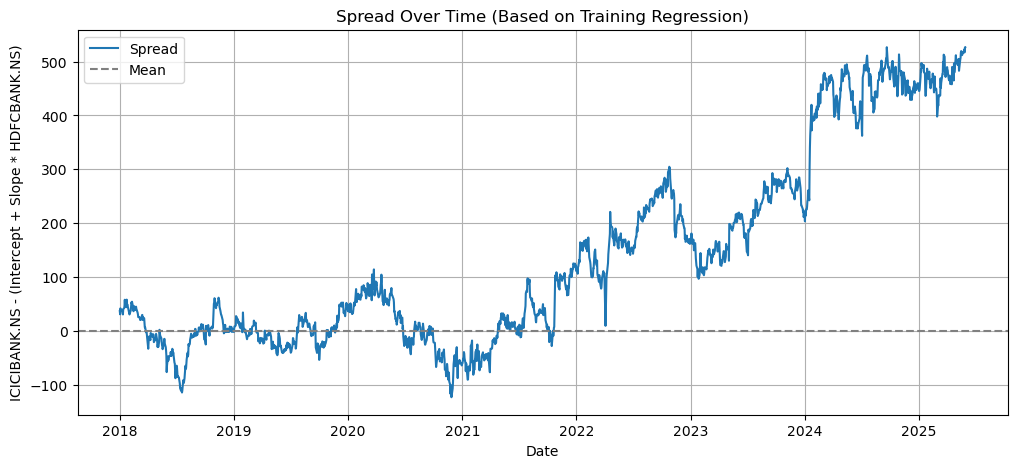

In [29]:
# calculate spread
spread = data[pick2] - (intercept + slope * data[pick1])
spread_mean = spread[train_data.index].mean()

# plot spread
plt.figure(figsize=(12, 5))
plt.plot(spread.index, spread, label="Spread")
plt.axhline(spread_mean, color="gray", linestyle="--", label="Mean")
plt.title("Spread Over Time (Based on Training Regression)")
plt.xlabel("Date")
plt.ylabel(f"{pick2} - (Intercept + Slope * {pick1})")
plt.legend()
plt.grid(True)
plt.show()

⚠️ Max drawdown triggered — strategy stopped at 2021-10-25


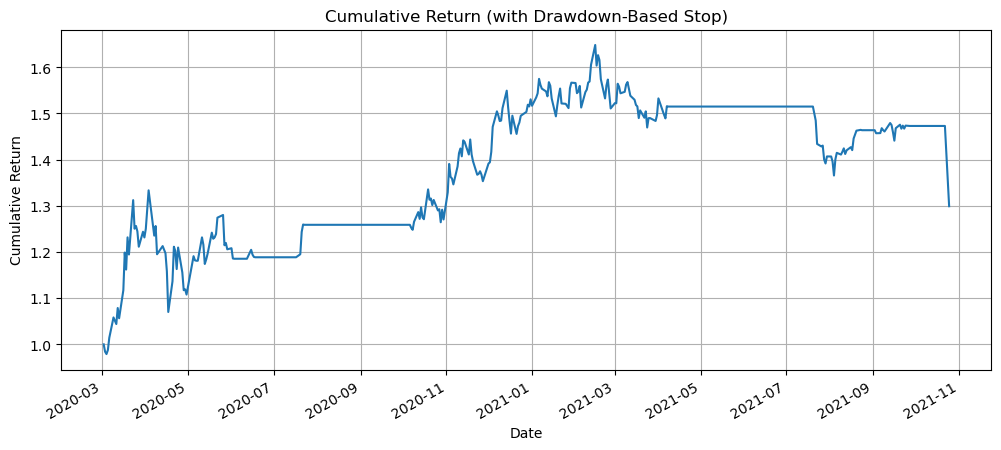

In [30]:
# static

results = run_static_strategy(pick1, pick2, data)

# find drawdown
cumulative = results["Cumulative Return"]
peak = cumulative.cummax()
drawdown = (cumulative - peak) / peak

# apply max drawdown
max_drawdown_threshold = -0.20  # stop if loss exceeds 20%
cutoff_index = drawdown[drawdown < max_drawdown_threshold].first_valid_index()

if cutoff_index is not None:
    results_trimmed = results.loc[:cutoff_index]
    print(f"⚠️ Max drawdown triggered — strategy stopped at {cutoff_index.date()}")
else:
    results_trimmed = results
    print("✅ No drawdown breach — strategy ran full duration")

# plot trimmed returns
plt.figure(figsize=(12, 5))
results_trimmed["Cumulative Return"].plot()
plt.title("Cumulative Return (with Drawdown-Based Stop)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()

In [31]:
# extract daily returns
daily_returns = results_trimmed["Strategy Return"] if "results_trimmed" in locals() else results["Strategy Return"]

# calculate daily mean and voltaility
mean_return = daily_returns.mean()
volatility = daily_returns.std()

# sharpe
sharpe_ratio = (mean_return / volatility) * np.sqrt(252)

# print
print(f"Mean Daily Return: {mean_return:.6f}")
print(f"Daily Volatility : {volatility:.6f}")
print(f"Sharpe Ratio     : {sharpe_ratio:.2f}")

Mean Daily Return: 0.000806
Daily Volatility : 0.018322
Sharpe Ratio     : 0.70
